In [ ]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc
import scipy.signal as sig

In [ ]:
Sr_i = 625
Sr_o = 48
vl = Sr_i * 48
vl

In [ ]:
# sample input signal -- at 10 kHz 
f_i = 10
w_i = 2 * np.pi * f_i
t = np.arange(vl)
s_i = np.exp(t * 1j * w_i / Sr_i)

In [ ]:
plt.plot(np.abs(np.fft.fft(s_i)/30000)[0:3000])

In [ ]:
def makeLPF(cutoff, rate, length, taps):
    fdi = np.zeros(length) * 1j
    print("length = %d" % length)
    co_idx = int(length * cutoff / float(rate))
    print(co_idx)
    fdi[0:co_idx] = 1 + 0j
    fdi[co_idx:co_idx+20] = np.linspace(1, 0, 20)
    fdi[int(length/2):] = np.flip(fdi[0:int(length/2)])
    
    tdi = np.fft.ifft(fdi)
    #plt.plot(tdi[0:200], label='pos')
    #plt.plot(tdi[-200:], label='neg')
    #print(tdi[-10:])
    # window it
    win = sig.windows.blackman(taps, sym=False)
    #win = np.ones(taps)
    tidx = int(taps/2)
    #plt.plot(win)
    
    tdi[tidx:taps] = tdi[0:tidx+1]
    tdi[0:tidx] = np.flip(tdi[1:tidx+1])
    #plt.plot(tdi, label='prewin')
    tdi[0:taps] = tdi[0:taps]*win
    #plt.plot(tdi, label='shift')
    
    tdi[taps:] = 0 + 0j
    tdi = np.real(tdi)
    fo = np.fft.fft(tdi)

    return fo, tdi, fdi
    

In [ ]:
class OSReSampler: 
    def __init__(self, FSin, FSout, min_time):
        from math import gcd
        g = gcd(FSin, FSout)  
        U = int(FSout / g)
        D = int(FSin / g)
        
        self.U = U
        self.D = D
  
        # the Fx buffer (in) must be a multiple of D, but
        # must also be large enough to provide a minimum buffer size
        # so the minimum number of samples is 
        min_in_samples = FSin * min_time
        # and k (Lx = k D) is
        k = int((min_in_samples + D - 1) / D)
        self.Lx = k * D
        self.Ly = int(self.Lx * U / D)
        
        
        # we're doing an overlap-and-save where we hold the
        # last D samples
        self.save_count = D
        self.save_buf = np.zeros(self.save_count)* 1j        
        self.in_buf_size = self.Lx - D
        self.out_buf_size = self.Ly - U
        self.discard_count = U

        extract_buckets = min(self.Ly, self.Lx)
        self.olh = int((extract_buckets + 1) / 2)
        self.ohh = self.Ly - self.olh     

        # make the de-aliasing filter... 
        cutoff = min(FSin, FSout)
        # Use the filter whether U > D or U < D. In the upsampling 
        # case it tapers the edges of the input spectrum to keep nasty things
        # from happening at the input-band-edge, at the expense of 20% of the
        # spectrum that you shouldn't have been trusting anyhow.
        self.lpf, _, _ = makeLPF(cutoff*0.4,FSin, self.Lx, 41)
    
    def getInBufSize(self):
        return self.in_buf_size
    
    def getOutBufSize(self):
        return self.out_buf_size
    
    def apply(self, inb):
        os_inbuf = np.concatenate((self.save_buf, inb))
        self.save_buf = inb[-self.save_count:]
        
        if os_inbuf.size != self.Lx:
            print("Input buffer length was %d, it should be %d" % (inb.size, self.getInBufSize()))
        
        # now get the DFT image
        fin = np.fft.fft(os_inbuf) #* self.lpf
        fin = fin * self.lpf
        fout = np.zeros(self.Ly) * 1j
        print("fin.size %d fout.size %d" % (fin.size, fout.size))
        fout[0:self.olh] = fin[0:self.olh]
        fout[-self.olh:] = fin[-self.olh:]
        
        # now invert
        pre_out = np.fft.ifft(fout)
        # throw away the first dirty camples
        return (self.Ly / self.Lx) * pre_out[self.discard_count:] 
   
 

In [ ]:
rsamp = OSReSampler(48000,625000,0.01)
# buffers are in 2304 - 48 entry chunks. (48 element overlap on input)
Lx = rsamp.getInBufSize()
tv = np.arange(Lx * 3)
print("inbuf %d" % Lx)


f1 = np.exp(1j * tv * np.pi/32) + np.exp(1j * tv * -np.pi / 71) #+ np.exp(1j * tv / 23)
# DC correct
print("f1 mean = %f %f" % (np.real(np.mean(f1)), np.imag(np.mean(f1))))
f1 = f1 - np.mean(f1)
# buffers are in 2304 - 48 entry chunks. (48 element overlap on input)

f2_lo = rsamp.apply(f1[0:Lx])
f2_hi = rsamp.apply(f1[Lx:2*Lx])
f2_very = rsamp.apply(f1[2*Lx:])
#f2 = FDResampler(U, D, f1)
f2_lo.size, np.mean(f1), np.mean(f2_hi), np.mean(f2_lo)
#np.sum(f2[0:mid] - f2_lo)  #+ #np.sum(f2[mid:] - f2_hi), np.max(np.real(f2[0:mid] - f2_lo)), np.max(np.real(f2[mid:] - f2_hi))

In [ ]:
#plt.plot(np.imag(f2_lo[-625:]))
#plt.plot(np.imag(f2_hi[0:625]))
#plt.plot(np.imag(f2_hi[-625:]))
#plt.plot(np.imag(f2_lo[0:625]))
fig,ax = plt.subplots()
#ax.plot(np.concatenate((f2_lo[-625:], f2_hi[0:625])))
ax.plot(np.concatenate((f2_lo, f2_hi, f2_very)))
#ax.plot(f2_hi)
f2_lo[0:10]
ax.grid()
f1.shape, f2_lo.shape

In [ ]:
f2 = np.concatenate((f2_lo, f2_hi))

f,v = sig.periodogram(f2, fs=625, window='blackman')
fif,vif = sig.periodogram(f1, fs=48, window='blackman')

fig,ax=plt.subplots()

ax.plot(fif, 20 * np.log10(vif))
ax.plot(f, 20 * np.log10(v))
ax.grid()
v.shape
np.mean(np.real(f1)), np.mean(np.imag(f1)), np.mean(f2)

In [ ]:
# how about the other way? 
downsamp = OSReSampler(625000,48000, 0.01)

inbuflen =  downsamp.getInBufSize()
print("inbuflen %d" % inbuflen)
iftv = np.arange(3 * inbuflen)
f1 = 0.5
f2 = 0.8
f3 = 73.0
fs = 625
w1 = 2 * np.pi * f1 / fs
w2 = 2 * np.pi * f2 / fs
w3 = 2 * np.pi * f3 / fs
ifsig = np.exp(1j * iftv * w1) + np.exp(1j * iftv * w2) + np.exp(1j * iftv * -w3)

audsig_0 = downsamp.apply(ifsig[0:inbuflen])
audsig_1 = downsamp.apply(ifsig[inbuflen:inbuflen*2])
audsig_2 = downsamp.apply(ifsig[inbuflen*2:])
inbuflen

In [ ]:
ifsig.size/2, audsig_1.size


In [ ]:
fig,ax = plt.subplots()
ax.plot(np.real(np.concatenate((audsig_0[-U:], audsig_1[0:U]))))
ax.plot(np.real(np.concatenate((audsig_1[-U:], audsig_2[0:U]))))
ax.plot(np.real(np.concatenate((audsig_0, audsig_1, audsig_2))))
audsig_0.size
ax.grid()
audsig_0.size

In [ ]:
audsig = np.concatenate((audsig_0, audsig_1, audsig_2))
audsig.size

f,v = sig.periodogram(audsig, fs=48, window='blackman')
fif,vif = sig.periodogram(ifsig, fs=625, window='blackman')

fig,ax=plt.subplots()
ax.plot(fif[1:-1], 20 * np.log10(vif[1:-1]))
ax.plot(f[1:-1], 20 * np.log10(v[1:-1]))

ax.grid()
v.shape, vif.shape

In [ ]:
fig,ax=plt.subplots()
ax.plot(f)

In [647]:
def myGCD(a, b):
    print("myGCD(%d, %d)" % (a, b))
    if b == 0:
        return a
    elif a < b:
        return myGCD(b, a)
    else:
        return myGCD(b, a % b)

In [649]:
myGCD(625000,48000)

myGCD(625000, 48000)
myGCD(48000, 1000)
myGCD(1000, 0)


1000

In [650]:
625000 % 48000

1000

In [652]:
myGCD(92322,53257)

myGCD(92322, 53257)
myGCD(53257, 39065)
myGCD(39065, 14192)
myGCD(14192, 10681)
myGCD(10681, 3511)
myGCD(3511, 148)
myGCD(148, 107)
myGCD(107, 41)
myGCD(41, 25)
myGCD(25, 16)
myGCD(16, 9)
myGCD(9, 7)
myGCD(7, 2)
myGCD(2, 1)
myGCD(1, 0)


1

In [655]:
def hw(s):
    b = np.arange(s)
    ang_inc = 2.0 * np.pi / (s-1)
    ret = 0.54 - 0.46 * np.cos(ang_inc * b)
    return ret

<IPython.core.display.Javascript object>


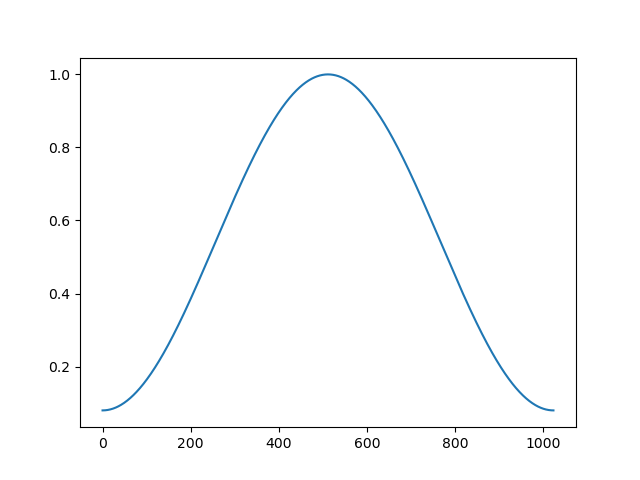

In [657]:
fig,ax = plt.subplots()
hw_1k = hw(1024)
hw_100k = hw(100 *  1024)
ax.plot(np.arange(hw_1k.size), hw_1k)
#ax.plot(np.arange(hw_100k.size) / 100, hw_100k)